# Lane Detection Pipeline


In this practice session, we will define a special computer vision pipeline. The goal of the pipeline is to detect lane lines in images and videos. We will use different images to check if we worked correctly. 
This exercise gives us the opportunity to apply what we learned in the lecture. The data (images and videos) used in this exercise are based on the course "Self Driving Car Engineer Nanodegree" from Udacity.

This notebook shows the complete pipeline with the following steps:

1. Load images and videos to check what kind of lanes we want to detect
2. Import the necessary libraries: Focus on OpenCV functions
3. Define Python functions for image processing
4. Define image processing pipeline
5. Apply image processing pipeline to images
6. Apply image processing pipeline to videos


---

## Input Video

First, have a look at the input video stream of our front facing dashcam.
(Remove the following cell for the video processing in the last step!)

## Import All Necessary Python Packages

In the next step, the Python packages needed for our functions are added. The focus here is the OpenCV package (called "cv2" in the imports) that includes all important image processing functions, e.g. canny edge detection and hough transformation.


In [6]:
import cv2
import math
import os

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
from moviepy.editor import VideoFileClip
from numpy import arange, array, linalg, ones
from pylab import plot, show

## Define All Necessary Image Processing Functions

We define all functions for processing the image in the following cell. These functions are used later when we execute the pipeline. Just defining the functions doesn't compute anything, yet.

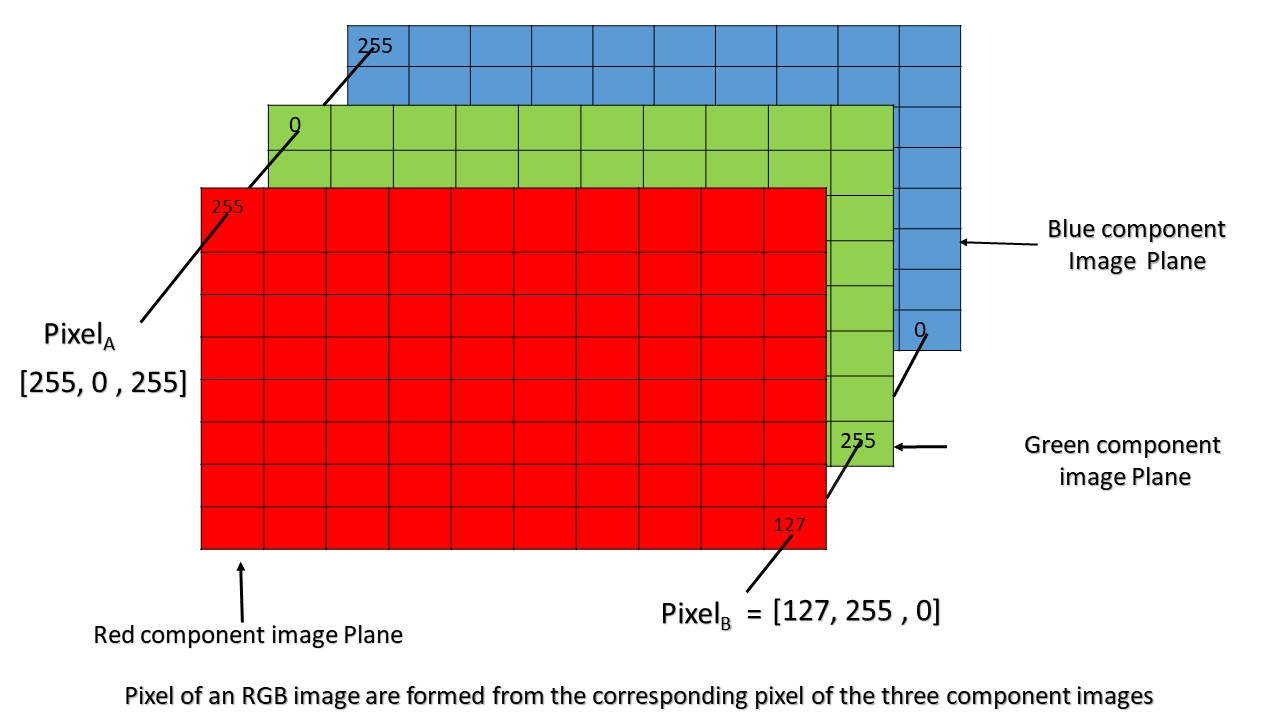

In [7]:
def grayscale(img):
    """
    Applies the Grayscale transform
    
    This will return an image with only one color channel.
    But NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'img_gray')
    you should call plt.imshow(img_gray, cmap='gray')
    
    It is quite unique to OpenCV that images are imported using the
    BGR color space. This is equivalent to the RGB color space,
    except the channels for red and blue are interchanged (RGB <=> BGR)
    
    So use BGR2GRAY if you read an image with cv2.imread():
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    Another elegant method would be to reverse the order of the
    third dimension, i.e. color channels:
    img_rgb = img_bgr[:, :, ::-1]
    """
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)


def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)


def gaussian_blur(img, kernel_size):
    """Applies a Gaussian noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)


def region_of_interest(img, vertices):
    """
    Applies an image mask

    Only keeps the region of the image defined by the polygon
    formed from 'vertices'. The rest of the image is set to black.
    """
    # defining a blank mask to start with
    mask = np.zeros_like(img)

    # defining a 3-channel or 1-channel white to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    # filling pixels inside the polygon defined by 'vertices' with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    # returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=8):
    """
    NOTE: this is the function you might want to use as a starting point
    once you want to average/extrapolate the line segments you detect to 
    map out the full extent of the lane.

    Think about things like separating line segments by their
    slope to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of
    the lines and extrapolate to the top and bottom of the lane.

    This function draws lines with color and thickness.
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below.
    """
    imshape = img.shape

    vertices = np.array([[(50, imshape[0]), (450, 320), (500, 320), (900, imshape[0])]], dtype=np.int32)
    left_x = []
    left_y = []
    right_x = []
    right_y = []

    left_x1_max = 200
    left_y1_max = imshape[0]
    left_x2_max = 450
    left_y2_max = 320

    right_x1_max = 500
    right_y1_max = 320
    right_x2_max = 870
    right_y2_max = imshape[0]

    for line in lines:
        for x1, y1, x2, y2 in line:

            x_values = float(x2 - x1)
            y_values = float(y2 - y1)
            slope = float(y_values / x_values)
            if slope < 0:
                # Ignore obviously invalid lines
                if slope > -.5 or slope < -.8:
                    continue

                left_x.append(x1)
                left_x.append(x2)
                left_y.append(y1)
                left_y.append(y2)

            else:
                # Ignore obviously invalid lines
                if slope < .5 or slope > .8:
                    continue
                right_x.append(x1)
                right_x.append(x2)
                right_y.append(y1)
                right_y.append(y2)

    right_x.append(right_x1_max)
    right_x.append(right_x2_max)
    right_y.append(right_y1_max)
    right_y.append(right_y2_max)

    left_x.append(left_x1_max)
    left_x.append(left_x2_max)
    left_y.append(left_y1_max)
    left_y.append(left_y2_max)

    x_right = np.asarray(right_x)
    y_right = np.asarray(right_y)
    A_right = array([x_right, ones(len(x_right))])
    w_right = linalg.lstsq(A_right.T, y_right)[0]  # obtaining the parameters
    line_right = w_right[0] * x_right + w_right[1] # regression line

    x_left = np.asarray(left_x)
    y_left = np.asarray(left_y)
    A_left = array([x_left, ones(len(x_left))])
    w_left = linalg.lstsq(A_left.T, y_left)[0]  # obtaining the parameters
    line_left = w_left[0] * x_left + w_left[1]  # regression line

    x1_right = min(x_right)
    x2_right = int((imshape[0] - w_right[1]) / w_right[0])
    y1_right = int(min(line_right))
    y2_right = imshape[0]

    x1_left = int((imshape[0] - w_left[1]) / w_left[0])
    x2_left = max(x_left)
    y1_left = imshape[0]
    y2_left = int(min(line_left))

    cv2.line(img, (x1_right, y1_right), (x2_right, y2_right), color, thickness)
    cv2.line(img, (x2_left, y2_left), (x1_left, y1_left), color, thickness)
    
    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    img: should be the output of a Canny transform

    Returns an image with hough lines drawn
    """
    lines_hough = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), 
                                  minLineLength=min_line_len, maxLineGap=max_line_gap)
    
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines_hough)

    return line_img


def weighted_img(img, initial_img, alpha=0.8, beta=1.0, gamma=0):
    """
    img: output of hough_lines(), a black image with lines drawn on it
    
    initial_img: image before any processing

    The resulting image is computed as follows:
    initial_img * alpha + img * beta + gamma
    
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, alpha, img, beta, gamma)


def get_slope(x1, y1, x2, y2):
    return (float(y2 - y1) / float(x2 - x1))

## Define the Function for Processing an Image

This is the overall function which processes an image step by step with different sub-functions. This function is called every time we process an image.

1. Load an image and get the scale of the image
2. Transfer image to grayscale
2. Apply gaussian blur
3. Apply the canny edge detection algorithm
4. Define a region of interest
5. Retrieve hough lines
6. Apply lane lines to image
7. Apply lane lines to video

In [8]:
def process_image(image):

    # Get the scale of the image
    imshape = image.shape
    
    # Transfer image to grayscale
    gray = grayscale(image)
    
    # Apply gaussian blur to image
    blur_gray = gaussian_blur(gray, 5)

    # Apply the canny edge detection algorithm
    canny_blur = canny(blur_gray, 100, 200)

    # Define a region of interest: focus on the street in front of the car
    vertices = np.array([[(50, imshape[0]), (450, 320), (500, 320), (900, imshape[0])]], dtype=np.int32)
    region_masked = region_of_interest(canny_blur, vertices)
    plt.imshow(region_masked)
    # Apply hough line detection to the image (just on the region of interest)
    hough_picture = hough_lines(region_masked, 2, np.pi / 180, 20, 50, 30)
    
    # Result: picture with edges and lines
    result = weighted_img(hough_picture, image)
    
    return result

## Find Lane Lines in Images

This is the main function which is loading an image, processing an image and applying the detected lane lines to the image. Afterwards, the new image is saved.

Loading Image solidWhiteCurve.jpg
Processing Image solidWhiteCurve.jpg
Saving Image solidWhiteCurve.jpg



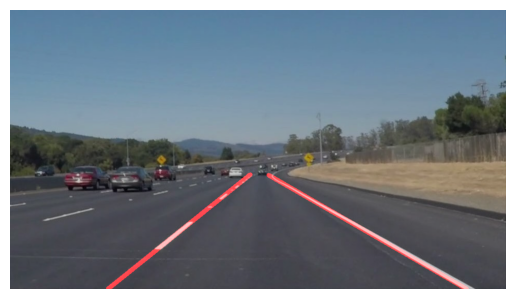

Loading Image solidWhiteRight.jpg
Processing Image solidWhiteRight.jpg
Saving Image solidWhiteRight.jpg



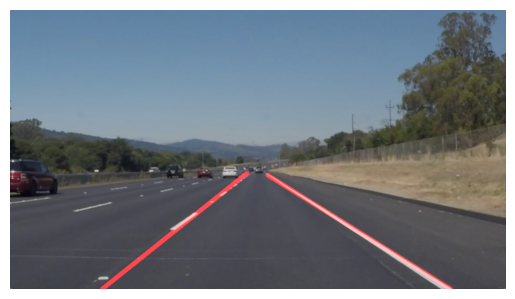

Loading Image solidYellowLeft.jpg
Processing Image solidYellowLeft.jpg
Saving Image solidYellowLeft.jpg



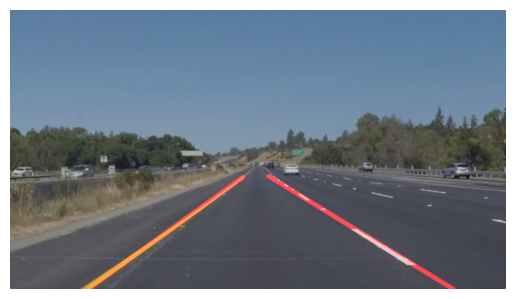

In [9]:
images = os.listdir('test_images/')

for img_file in images:
    
    print(f'Loading Image {img_file}')
    image = mpimg.imread('test_images/' + img_file)

    print(f'Processing Image {img_file}')
    processed_image = process_image(image)

    print(f'Saving Image {img_file}\n')
    mpimg.imsave('output_images/lines-' + img_file, processed_image)
    
    plt.axis('off')
    plt.imshow(processed_image)
    plt.show()

## Find Lane Lines in Videos

This is the main function which is loading a video, splitting the video into images, processing each image and applying the detected lane lines to each image. Afterwards, the processed images are combined to a new video.

Moviepy - Building video output_videos/output_video.mp4.
Moviepy - Writing video output_videos/output_video.mp4



Moviepy - Done !
Moviepy - video ready output_videos/output_video.mp4


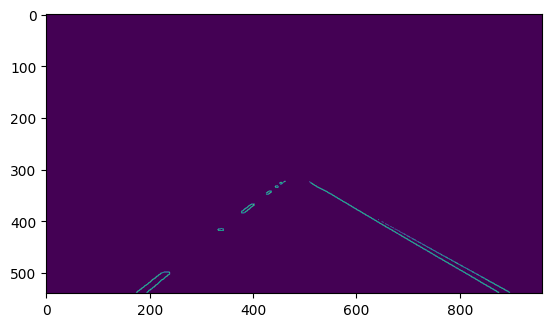

In [10]:
clip = VideoFileClip('test_videos/solidWhiteRight.mp4')  # Choose video clip
white_clip = clip.fl_image(process_image) # NOTE: this function expects color images;
white_output = 'output_videos/output_video.mp4'
white_clip.write_videofile(white_output, audio=False)

## Improvements


Now it's your turn to experiment with the notebook and improve the lane detection pipeline. Feel free to reach out to us with ideas and comments.